In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# --- Célula 2: Carregamento dos Dados (VERSÃO FINAL) ---

# CORREÇÃO: Apontamos para a nova tabela criada pelo notebook de engenharia de features avançada.
path_final_table = '../data/processed/modeling_table.parquet'
df = pd.read_parquet(path_final_table)

print("Tabela final para modelagem carregada com sucesso.")
print(f"A tabela contém {df.shape[0]} dias e {df.shape[1]} colunas.")
display(df.head())

Tabela final para modelagem carregada com sucesso.
A tabela contém 1343 dias e 20 colunas.


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria,total_mwh_restrito_go,saldo_intercambio_seco,ear_percentual_seco,ena_percentual_mlt_seco,carga_media_7d,carga_std_7d,geracao_media_7d,ear_ontem,ear_diff_3d,margem_oferta_demanda,pressao_demanda_ear
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-08,0.8705,baixo,80746.0903,78702.8934,-2043.1969,0.0,0.0,0.0,0.0,0.0,0.0,30.715300,113.96260071,82135.303043,5867.964889,0.0,29.898399,2.2428,-78702.8934,2561.501251
2022-01-09,0.0000,baixo,68542.9283,71458.6032,2915.6749,0.0,0.0,0.0,0.0,0.0,0.0,31.641300,123.81639862,82229.413357,5657.370818,0.0,30.715300,2.5460,-71458.6032,2257.683026
2022-01-10,0.0000,baixo,77476.3635,80265.2348,2788.8713,0.0,0.0,0.0,0.0,0.0,0.0,32.543900,136.90319824,82031.153671,5705.052217,0.0,31.641300,2.6455,-80265.2348,2465.610447
2022-01-11,0.0000,baixo,83291.9332,81628.8497,-1663.0835,0.0,0.0,0.0,0.0,0.0,0.0,33.558399,146.60839844,81477.070257,5495.664839,0.0,32.543900,2.8431,-81628.8497,2431.717081
2022-01-12,0.0000,baixo,79838.0764,81252.1357,1414.0593,0.0,0.0,0.0,0.0,0.0,0.0,34.514900,151.69160461,80469.784686,4610.984392,0.0,33.558399,2.8736,-81252.1357,2353.435787


In [3]:
# A coluna 'nivel_risco' é nosso alvo (o que queremos prever).
y = df['nivel_risco']

# As features (X) são todas as outras colunas numéricas.
X = df.drop(columns=['nivel_risco', 'deficit_diario_mwh'])

print("Dados separados em Features (X) e Alvo (y):")
print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

Dados separados em Features (X) e Alvo (y):
Formato de X: (1343, 18)
Formato de y: (1343,)


In [4]:
# PASSO DE VERIFICAÇÃO FINAL: Contagem de classes com o dataset completo.
print("--- Contagem de dias por classe de risco (Dataset Completo) ---")
print(y.value_counts())

# Mapeamos nossas 3 classes de risco para números.
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Dividir os dados em treino e teste.
# Com a nova distribuição de classes, o 'stratify' agora deve funcionar sem erros.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print("\nDados divididos em conjuntos de treino e teste com sucesso.")

--- Contagem de dias por classe de risco (Dataset Completo) ---
nivel_risco
baixo    1315
medio      18
alto       10
Name: count, dtype: int64

Dados divididos em conjuntos de treino e teste com sucesso.


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features escalonadas com sucesso.")

Features escalonadas com sucesso.


In [6]:
# --- Célula 6: Data Augmentation com SMOTE (VERSÃO CORRIGIDA E ROBUSTA) ---

# Esta é a etapa de Data Augmentation.
# SMOTE irá criar exemplos sintéticos das classes minoritárias ('medio' e 'alto').

# IMPORTANTE: Aplicamos o SMOTE APENAS nos dados de TREINO para evitar vazamento de dados.
print("Contagem de classes de treino ANTES do SMOTE:")
print(y_train.value_counts())

# --- CORREÇÃO APLICADA AQUI ---
# O parâmetro k_neighbors do SMOTE deve ser menor que o número de amostras na menor classe.
# Vamos calcular o valor máximo possível dinamicamente.
min_class_count = y_train.value_counts().min()
# O número de vizinhos deve ser no máximo o (número de amostras - 1).
# Garantimos que seja pelo menos 1, caso a classe tenha apenas 2 membros.
k_neighbors_smote = max(1, min_class_count - 1)

print(f"\nA menor classe tem {min_class_count} amostras. Ajustando k_neighbors do SMOTE para {k_neighbors_smote}.")

# Criamos uma instância do SMOTE com o número de vizinhos ajustado.
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
# -----------------------------

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nContagem de classes de treino DEPOIS do SMOTE:")
print(y_train_resampled.value_counts())
print("\nShape de X_train após resample:", X_train_resampled.shape)

Contagem de classes de treino ANTES do SMOTE:
nivel_risco
0    920
1     13
2      7
Name: count, dtype: int64

A menor classe tem 7 amostras. Ajustando k_neighbors do SMOTE para 6.

Contagem de classes de treino DEPOIS do SMOTE:
nivel_risco
0    920
2    920
1    920
Name: count, dtype: int64

Shape de X_train após resample: (2760, 18)


In [7]:
# XGBoost é um modelo poderoso baseado em árvores de decisão.
model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    random_state=42,
    eval_metric='mlogloss'
)

# Treinamos o modelo com os dados de treino AUMENTADOS pelo SMOTE.
print("Treinando o modelo XGBoost...")
model.fit(X_train_resampled, y_train_resampled)
print("Treinamento concluído.")

Treinando o modelo XGBoost...
Treinamento concluído.


Fazendo previsões no conjunto de teste...

Acurácia do Modelo XGBoost: 92.06%

Relatório de Classificação:
              precision    recall  f1-score   support

       baixo       0.98      0.94      0.96       395
       medio       0.00      0.00      0.00         5
        alto       0.00      0.00      0.00         3

    accuracy                           0.92       403
   macro avg       0.33      0.31      0.32       403
weighted avg       0.96      0.92      0.94       403



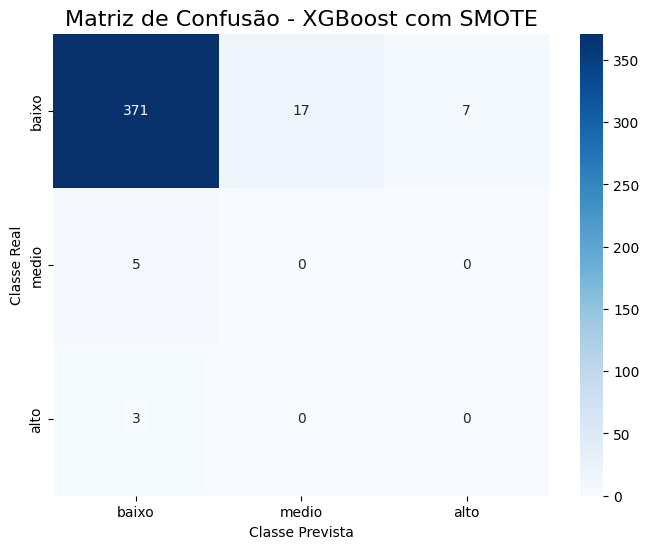

In [8]:
# Fazemos previsões no conjunto de teste ORIGINAL (não aumentado).
print("Fazendo previsões no conjunto de teste...")
y_pred = model.predict(X_test_scaled)

print(f"\nAcurácia do Modelo XGBoost: {accuracy_score(y_test, y_pred):.2%}\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=mapeamento_risco.keys()))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title('Matriz de Confusão - XGBoost com SMOTE', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

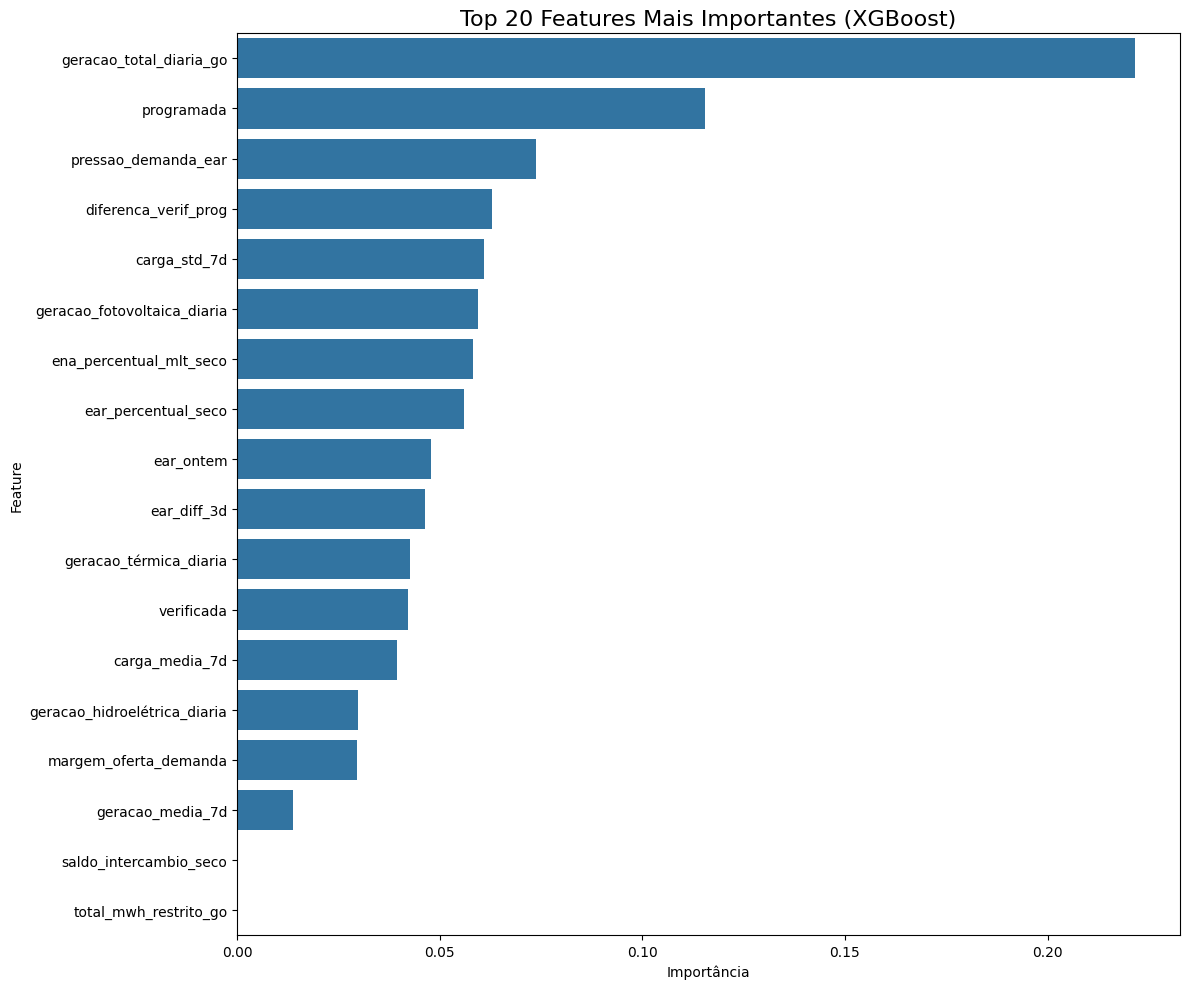

In [9]:
# O XGBoost nos diz quais features foram mais importantes para a decisão do modelo.
importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Mostra as 20 mais importantes
plt.title('Top 20 Features Mais Importantes (XGBoost)', fontsize=16)
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()